## Plot a particular set of correlations extracted from the code.
## Craig Lage - 14Feb19

In [1]:
from pylab import *
import os, sys, glob, time, scipy
from scipy import stats
import eups
from lsst.daf.persistence import Butler
%matplotlib inline

In [13]:
REPO_DIR = '/home/cslage/Research/LSST/code/notebooks/notebooks_2019_02_06/stand_alone_13feb19/flats_repo_itl_quad_zero'
bfk_butler = Butler(REPO_DIR+'/rerun/test')
# Note ITL uses raftName R02 and detector 2
# E2V uses raftName R00 and detector 0
bf_kernel = bfk_butler.get('brighterFatterKernel', dataId={'raftName': 'R02', 'detectorName': 'S00',
                                                              'detector': 2})
means = bf_kernel.means
xcorrs = bf_kernel.xcorrs
meanXcorrs = bf_kernel.meanXcorrs

In [4]:
# Look at the values for a particular flux
amp = 'C04'
flux = 18

print(" %s mean = "%(amp),means[amp][flux])
print(" %s xcorr[0,0] = "%(amp),xcorrs[amp][flux][0,0])
print(" %s xcorr[1,0] = "%(amp),xcorrs[amp][flux][1,0])
print(" %s xcorr[0,1] = "%(amp),xcorrs[amp][flux][0,1])
print(" %s meanXcorr[0,0] = "%(amp),meanXcorrs[amp][8,8]) 
print(" %s meanXcorr[0,1] = "%(amp),meanXcorrs[amp][8,9])

 C04 mean =  [132438.86473017593, 132500.65820848662]
 C04 xcorr[0,0] =  6.971680902119191e-07
 C04 xcorr[1,0] =  -6.656672796169795e-08
 C04 xcorr[0,1] =  -1.9624971231997473e-07
 C04 meanXcorr[0,0] =  1.299514982276562e-06
 C04 meanXcorr[0,1] =  -6.870725472760255e-08


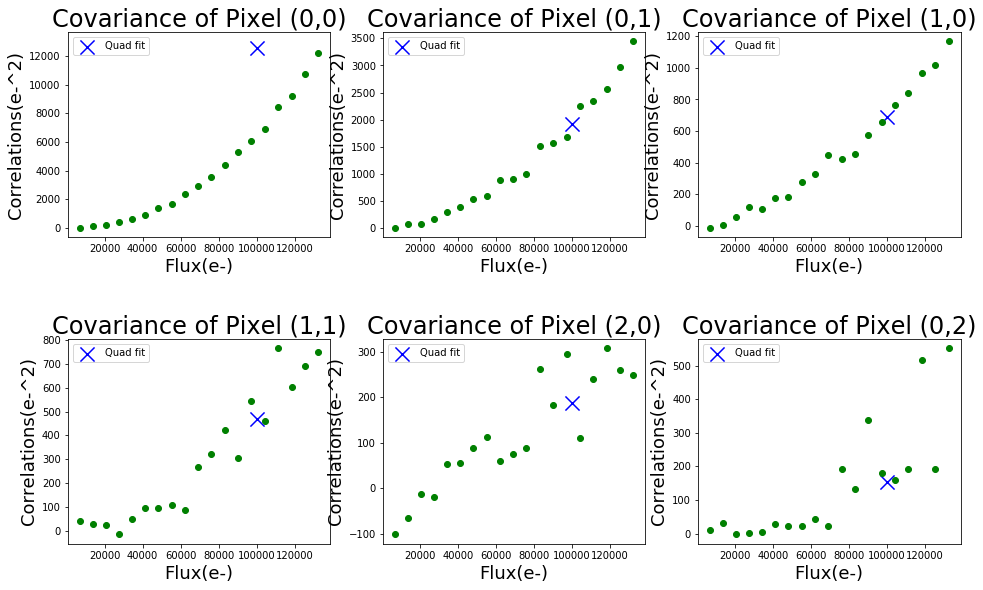

In [14]:
# Looking at just keeping the quadratic part of the covariance
# Note the C00 is off because it has been adjusted to force zero sum
amp = 'C04'
flux_value = 100000.0
figure(figsize=(16,32))
subplots_adjust(hspace=0.5)
plotnum = 0
flux = []
for values in means[amp]:
    flux.append((values[0]+values[1])/2.0)
flux = array(flux)

#for (ii,jj) in [(0,0),(0,1),(1,0),(1,1),(2,0),(0,2),(2,1),(1,2),(2,2),(3,0),(4,0),(5,0),(0,3),(0,4),(0,5)]:
for (ii,jj) in [(0,0),(0,1),(1,0),(1,1),(2,0),(0,2)]:
    cov = []
    flux = []
    plotnum += 1
    subplot(6,3,plotnum)
    title("Covariance of Pixel (%d,%d)"%(ii,jj),fontsize=24)
    for i in range(len(means[amp])):
        xcorr = xcorrs[amp][i][ii,jj]
        if ii == 0 and jj == 0:
            #if xcorr > 0:
            cov.append(xcorr)
            flux.append((means[amp][i][0] + means[amp][i][1])/2.0)
        else:
            #if xcorr < 0:
            cov.append(-xcorr)
            flux.append((means[amp][i][0] + means[amp][i][1])/2.0)

    cov = array(cov)
    flux = array(flux)
    cov = cov*flux*flux
    if ii == 0 and jj == 0:
        cov_value = meanXcorrs[amp][8+jj,8+ii]*flux_value*flux_value
    else:
        cov_value = -meanXcorrs[amp][8+jj,8+ii]*flux_value*flux_value
    plot(flux,cov,marker='o',color='green',ls='None')    
    #coefs = np.polyfit(flux*flux,cov,1)

    scatter([flux_value],[cov_value],marker='x',color = 'blue',s=200, label = "Quad fit")

    #xplot=linspace(0.0, 150000.0, 100)
    #yplot = coefs[0]*xplot*xplot# + coefs[1]*xplot + coefs[2]
    #plot(xplot,yplot,color='green',ls='--')
    #xlim(0,40000)
    #ylim(-50,400)

    xlabel("Flux(e-)", fontsize=18)
    ylabel("Correlations(e-^2)",fontsize=18)
    legend(loc='upper left')
    
savefig(REPO_DIR+'/rerun/test/plots/Keep_Quad_%s.pdf'%amp)

-1.35 -7.157465247679417 -0.7569632040189955


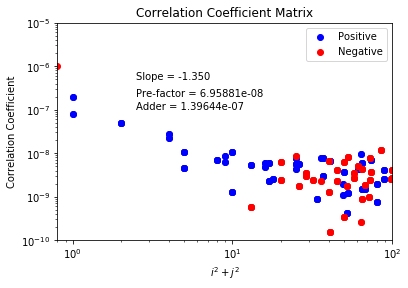

In [15]:
# Plot the correlations as a function of pixel 
amp = 'C14'
covsteps = 8
posrs = []
negrs = []
poscs = []
negcs = []
fitrs = []
fitcs = []
for ii in range(17):
    for jj in range(17):
        r2 = (ii-8)**2 + (jj-8)**2
        value = meanXcorrs[amp][ii,jj]
        if ii == 8 and jj == 8:
            negcs.append(abs(value))
            negrs.append(0.8)
        elif value < 0.0:
            poscs.append(abs(value))
            posrs.append(r2)
            if r2 > 1.1 and r2 < 20.0:
                fitrs.append(log10(r2))
                fitcs.append(log10(abs(value)))
        else:
            negcs.append(abs(value))
            negrs.append(r2)
slope, intercept, r_value, p_value, std_err = stats.linregress(fitrs,fitcs)
slope = -1.35
print(slope,intercept, r_value)
figure()
title("Correlation Coefficient Matrix")
scatter(posrs, poscs, color='blue', marker = 'o', label = 'Positive')
scatter(negrs, negcs, color='red', marker = 'o', label = 'Negative')

pre_factor = 10**intercept
adder = 2.0 * np.pi * pre_factor / ((2.0*abs(slope) - 2) * 8.5**(2.0*abs(slope) - 2.0))
text(2.5, 5E-7, "Slope = %.3f"%slope)
text(2.5, 2E-7, "Pre-factor = %g"%pre_factor)
text(2.5, 1E-7, "Adder = %g"%adder)
xplot = linspace(1.0,200,100)
yplot = 10.0**intercept * xplot**(slope)
#plot(xplot,yplot,ls='--',color='green')
xscale('log')
yscale('log')
xlim(0.8,100)
ylim(1E-10,1E-5)
xlabel("$i^2 + j^2$")
ylabel("Correlation Coefficient")
def ModelCov(ii,jj,intercept,slope):
    r2 = float(ii**2 + jj**2)
    return 10.0**intercept * r2**(slope)

modelrs = []
modelcs = []
for ii in range(covsteps):
    for jj in range(covsteps):
        r2 = ii**2 + jj**2
        if ii > 2 or jj > 2:
            cov_mean = ModelCov(ii,jj,intercept,slope)
            modelrs.append(r2)
            modelcs.append(cov_mean)
#scatter(modelrs,modelcs,marker='x',s=100,label='Model')
legend()#bbox_to_anchor=(0.80, 0.80), loc=2, borderaxespad=0., fontsize = 12)

savefig(REPO_DIR+'/rerun/test/plots/Correlations_%s.pdf'%amp)

